In [1]:
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import os
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
#from astropy.modeling.models import Schechter1D
import astropy.constants as ac
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker
from uncertainties import ufloat

In [2]:
191*900/60/60

47.75

In [3]:
from matplotlib import rc                # Establece parámetros iniciales al grupo
rc('text', usetex=False)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # Controla tamaño de texto por defecto
plt.rc('axes', titlesize=BIGGER_SIZE)    # Tamaño de las fuentes de los títulos
# Tamaño de las fuentes de los ejes x e y
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje x
plt.rc('ytick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje y
plt.rc('legend', fontsize=SMALL_SIZE)    # Tamaño de las leyendas
# Tamaño de la fuente del título de la figura
plt.rc('figure', titlesize=BIGGER_SIZE)

In [4]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # Create a universe model

In [5]:
def abmag(mag, err):
    flux = 3631 * 10**(-0.4*mag)
    err_p = np.abs(flux*(-0.4 *np.log(10))*err)
    return flux, err_p

In [6]:
def volume_redshift(z, area):
    
    err = 0.01
    zmin = z-err
    zmax = z+err
    "Obstains the volume given a minimum and maximum redshift, using the cosmology comoving distance"
    D_min = cosmo.luminosity_distance(zmin)
    D_max = cosmo.luminosity_distance(zmax)

    #else:
    volume_min = (4/3 * np.pi * (D_min ** 3))/(1+zmin)**3
    volume_max = (4/3 * np.pi * (D_max ** 3))/(1+zmax)**3
    volume =  (volume_max - volume_min)/(4*np.pi)*area*(np.pi/180)**2
    #
    #volume = cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)
    radianes = (area * (np.pi / 180)**2)
    #volume = (cosmo.comoving_volume(z+err) - cosmo.comoving_volume(z-err))*(radianes/4*np.pi)
    return volume.value 

In [7]:
def flux_lum(z, mag, err):
    flux, err_p = abmag(mag, err)
    #print(err_p)
    # Convert from F_nu to F_lambda
    f_lam = []
    e_f = []
    for f, f_nu in enumerate(flux):
        wavelength = 9640*u.AA #AA
        c_s = ac.c.to(u.AA/u.s)
        f_n = (92*f_nu*u.Jy).to(u.erg/u.s/u.cm**2/u.Hz)
        f_lambda = ((c_s / wavelength**2) * f_n)
        f_lam.append(f_lambda.value)
        err_f = (err_p[f]/f_nu)*err_p[f]
        e_f.append(err_f)
        #print(f_lambda) #erg / (Angstrom cm2 Hz s2)
    
    e_f = np.array(e_f)
    #print(e_f[0])
    f_lam = np.array(f_lam)
    #f_lam = f_lam*u.erg/u.cm**2/u.s
    phi = []
    lum = []
    lum_log = []
    e_L = []
    for j, flux_ in enumerate(f_lam):

        D = cosmo.luminosity_distance(z)
        d_cm = D.to(u.cm)
        err_L = (e_f[j]/flux_)*e_f[j]
        e_L.append(err_L)
        L = (flux_)*(4*np.pi*(d_cm**2))
        lum.append(L.value)
        lum_log.append(np.log10(L.value))
        
    e_L = np.array(e_L)
    lum = np.array(lum)
    lum_log = np.array(lum_log)

    
    return lum_log, lum, f_lam, e_L

In [8]:
def lum_mag(lum):
    result =  -2.5*np.log10(lum/3.846e33)
    return result

In [9]:
table = Table.read('NSF1_Bagpipes_NO_AGN.fits')

In [10]:
def sch(phis, L, Ls, alpha):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha)*np.exp(-L/Ls)
    return phi

In [11]:
mask1 =  (0 < table['redshift_50']) & (table['redshift_50'] < 0.7)

data_a =table[mask1]

In [12]:
mask2 =  (0.7 < table['redshift_50']) & (table['redshift_50'] < 1.3)

data_b = table[mask2]

In [13]:
mask3 =  (1.3 < table['redshift_50']) & (table['redshift_50'] < 2)
data_c = table[mask3]

In [14]:
al = np.mean(data_a['redshift_50']-data_a['redshift_16'])
ah = np.mean(data_a['redshift_84']-data_a['redshift_50'])
bl = np.mean(data_b['redshift_50']-data_b['redshift_16'])
bh = np.mean(data_b['redshift_84']-data_b['redshift_50'])
cl = np.mean(data_c['redshift_50']-data_c['redshift_16'])
ch = np.mean(data_c['redshift_84']-data_c['redshift_50'])

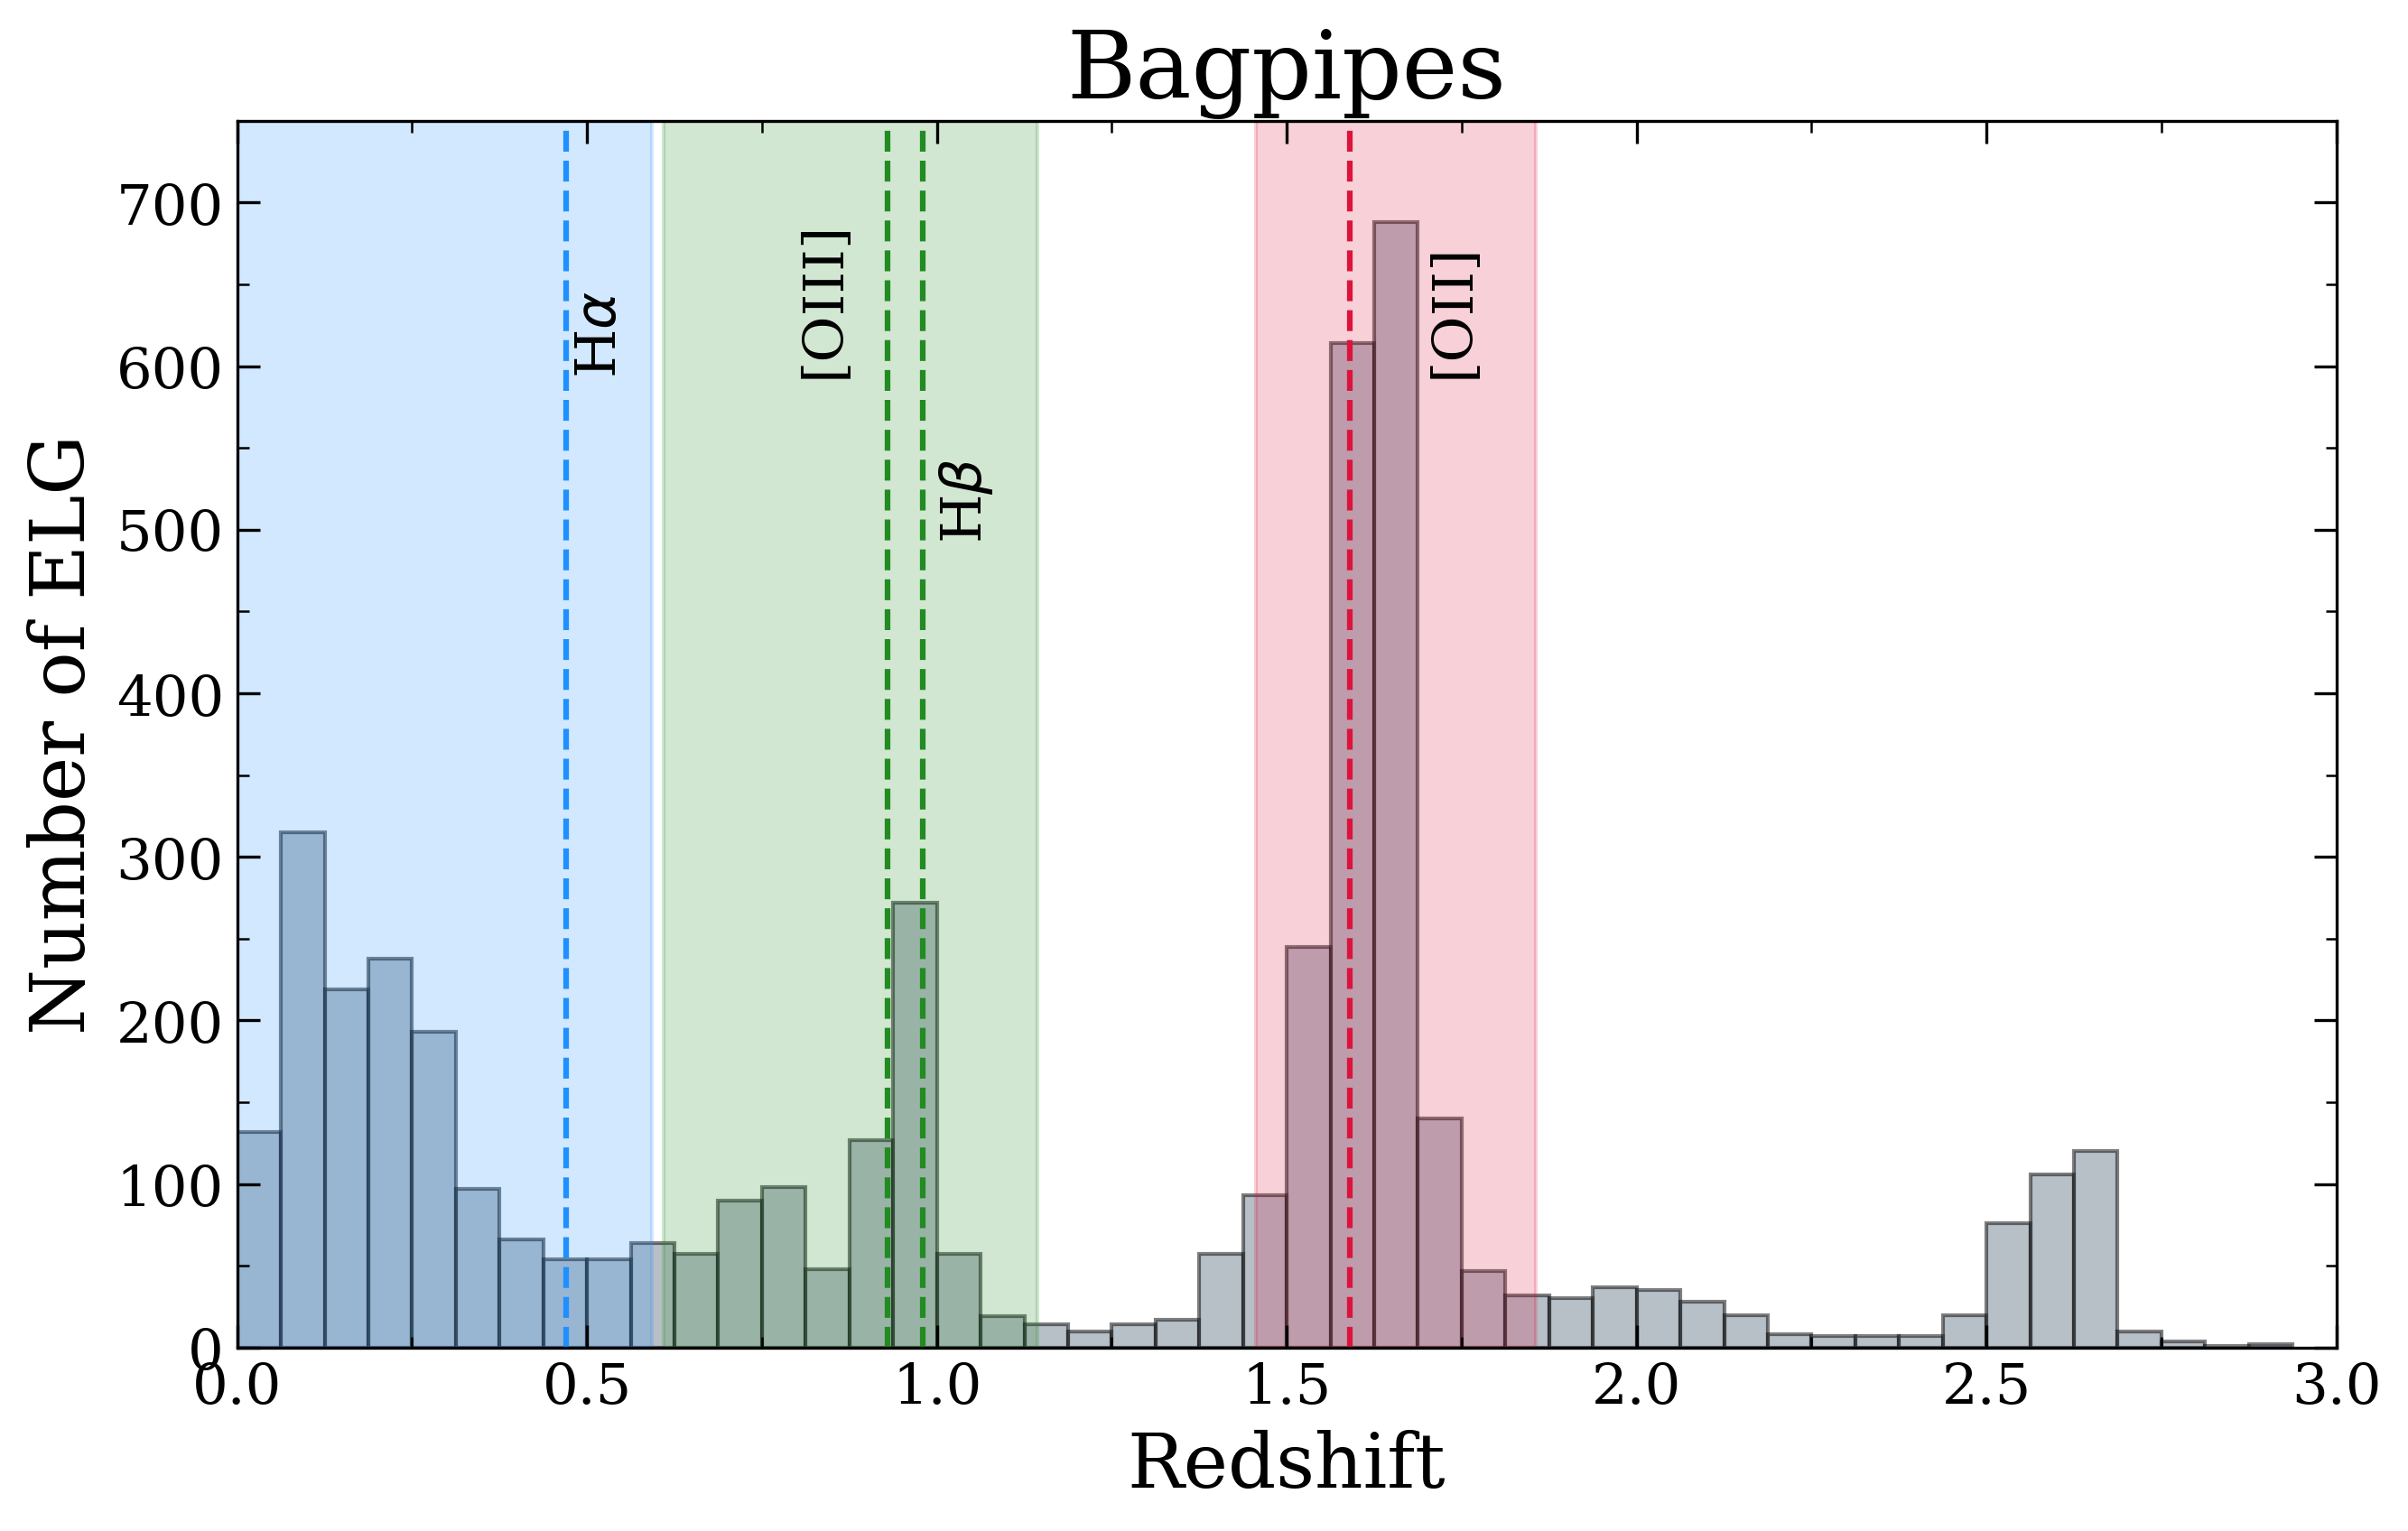

In [15]:
fig,ax=plt.subplots(figsize=(10,6), dpi=300)

bins = np.arange(0,3,0.0625)


ax.hist(table['redshift_50'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')
ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0.47-ah, 0.47+al, alpha=0.2, color='dodgerblue')
ax.text(0.48, 600, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.98,0,1000, linestyle ='dashed', color = 'forestgreen')
#ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(1, 500, r'H$\beta$', size = 15, rotation='vertical')

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.93-bh, 0.93+bl, alpha=0.2, color='forestgreen')
ax.text(0.8, 600, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.59-ch, 1.59+cl, alpha=0.2, color='crimson')
ax.text(1.7, 600, r'[OII]', size = 15, rotation='vertical')

# ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'crimson')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
# ax.text(2.5, 650, r'MgII', size = 15, rotation='vertical')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', bottom=True, top=True, direction='in', length=3)
#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
ax.set_xlim(0,3)
ax.set_ylim(0,750)
ax.set_title('Bagpipes')
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

In [16]:
bins

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
       1.5   , 1.5625, 1.625 , 1.6875, 1.75  , 1.8125, 1.875 , 1.9375,
       2.    , 2.0625, 2.125 , 2.1875, 2.25  , 2.3125, 2.375 , 2.4375,
       2.5   , 2.5625, 2.625 , 2.6875, 2.75  , 2.8125, 2.875 , 2.9375])

In [17]:
print(1.59-ch, 1.59+cl)

1.4563703228014209 1.8553277139269122


# H$\alpha$

In [18]:
mask_H =  (0.47-ah < data_a['redshift_50']) & (data_a['redshift_50'] < 0.47+al)
H_a = data_a[mask_H]

In [19]:
print(len(H_a))

1398


In [20]:
phi_star = 10**(-3.16) #* (u.Mpc ** -3)
L_star = (10**(41.72))
alpha = -1.75

In [21]:
aper = 2
H_flu = np.array([H_a['FLUX_APER_1'][i][aper] for i in range(len(H_a))])

In [22]:
H_mag = np.array([H_a['MAG_APER_1'][i][aper] for i in range(len(H_a))])
H_mag_err = np.array([H_a['MAGERR_APER_1'][i][aper] for i in range(len(H_a))])

l_H = flux_lum(0.47, H_mag, H_mag_err)


print(sigma_clipped_stats(l_H[3]))

(0.14456415406143344, 0.10558256662131077, 0.142656019134544)


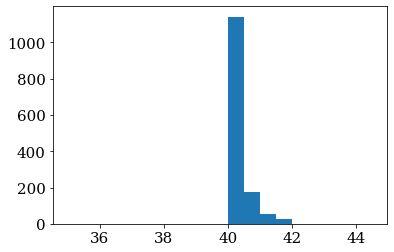

In [23]:
b = np.arange(35, 45,0.5)
alf_H, blf, clf =plt.hist(l_H[0], bins = b) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [24]:
len(alf_H)

19

In [25]:
bx_H = (b[0:-1]+b[1:])/2

binsize_H = bx_H[1]-bx_H[0]

lss_H = np.linspace(38,44,100)

In [26]:
vol_H = volume_redshift(0.47,2.94)

numb_ =  np.logspace((38),(44),100)
phia = sch(phi_star, numb_, L_star, alpha)

#Ly2007
phi_lyH = 10**(-2.40)
L_starLyH = 10**(41.29)
alphaLyH = -1.28
phi_LyH = sch(phi_lyH, numb_,L_starLyH, alphaLyH)

#Hayashi2016

phi_lyHa = 10**(-3.45)
L_starLyHa = 10**(41.86)
alphaLyHa = -1.75
phi_LyHa = sch(phi_lyHa, numb_,L_starLyHa, alphaLyHa)


phi_star_min = 10**(-3.16 -0.09) #* (u.Mpc ** -3)
L_star_min = (10**(41.72-0.09))
phi_min_H = sch(phi_star_min, numb_, L_star_min, alpha)


phi_star_max = 10**(-3.16 +0.09) #* (u.Mpc ** -3)
L_star_max = (10**(41.72 +0.09))
phi_max_H = sch(phi_star_max, numb_, L_star_max, alpha)

In [27]:
vol_H

191049.7839893171

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


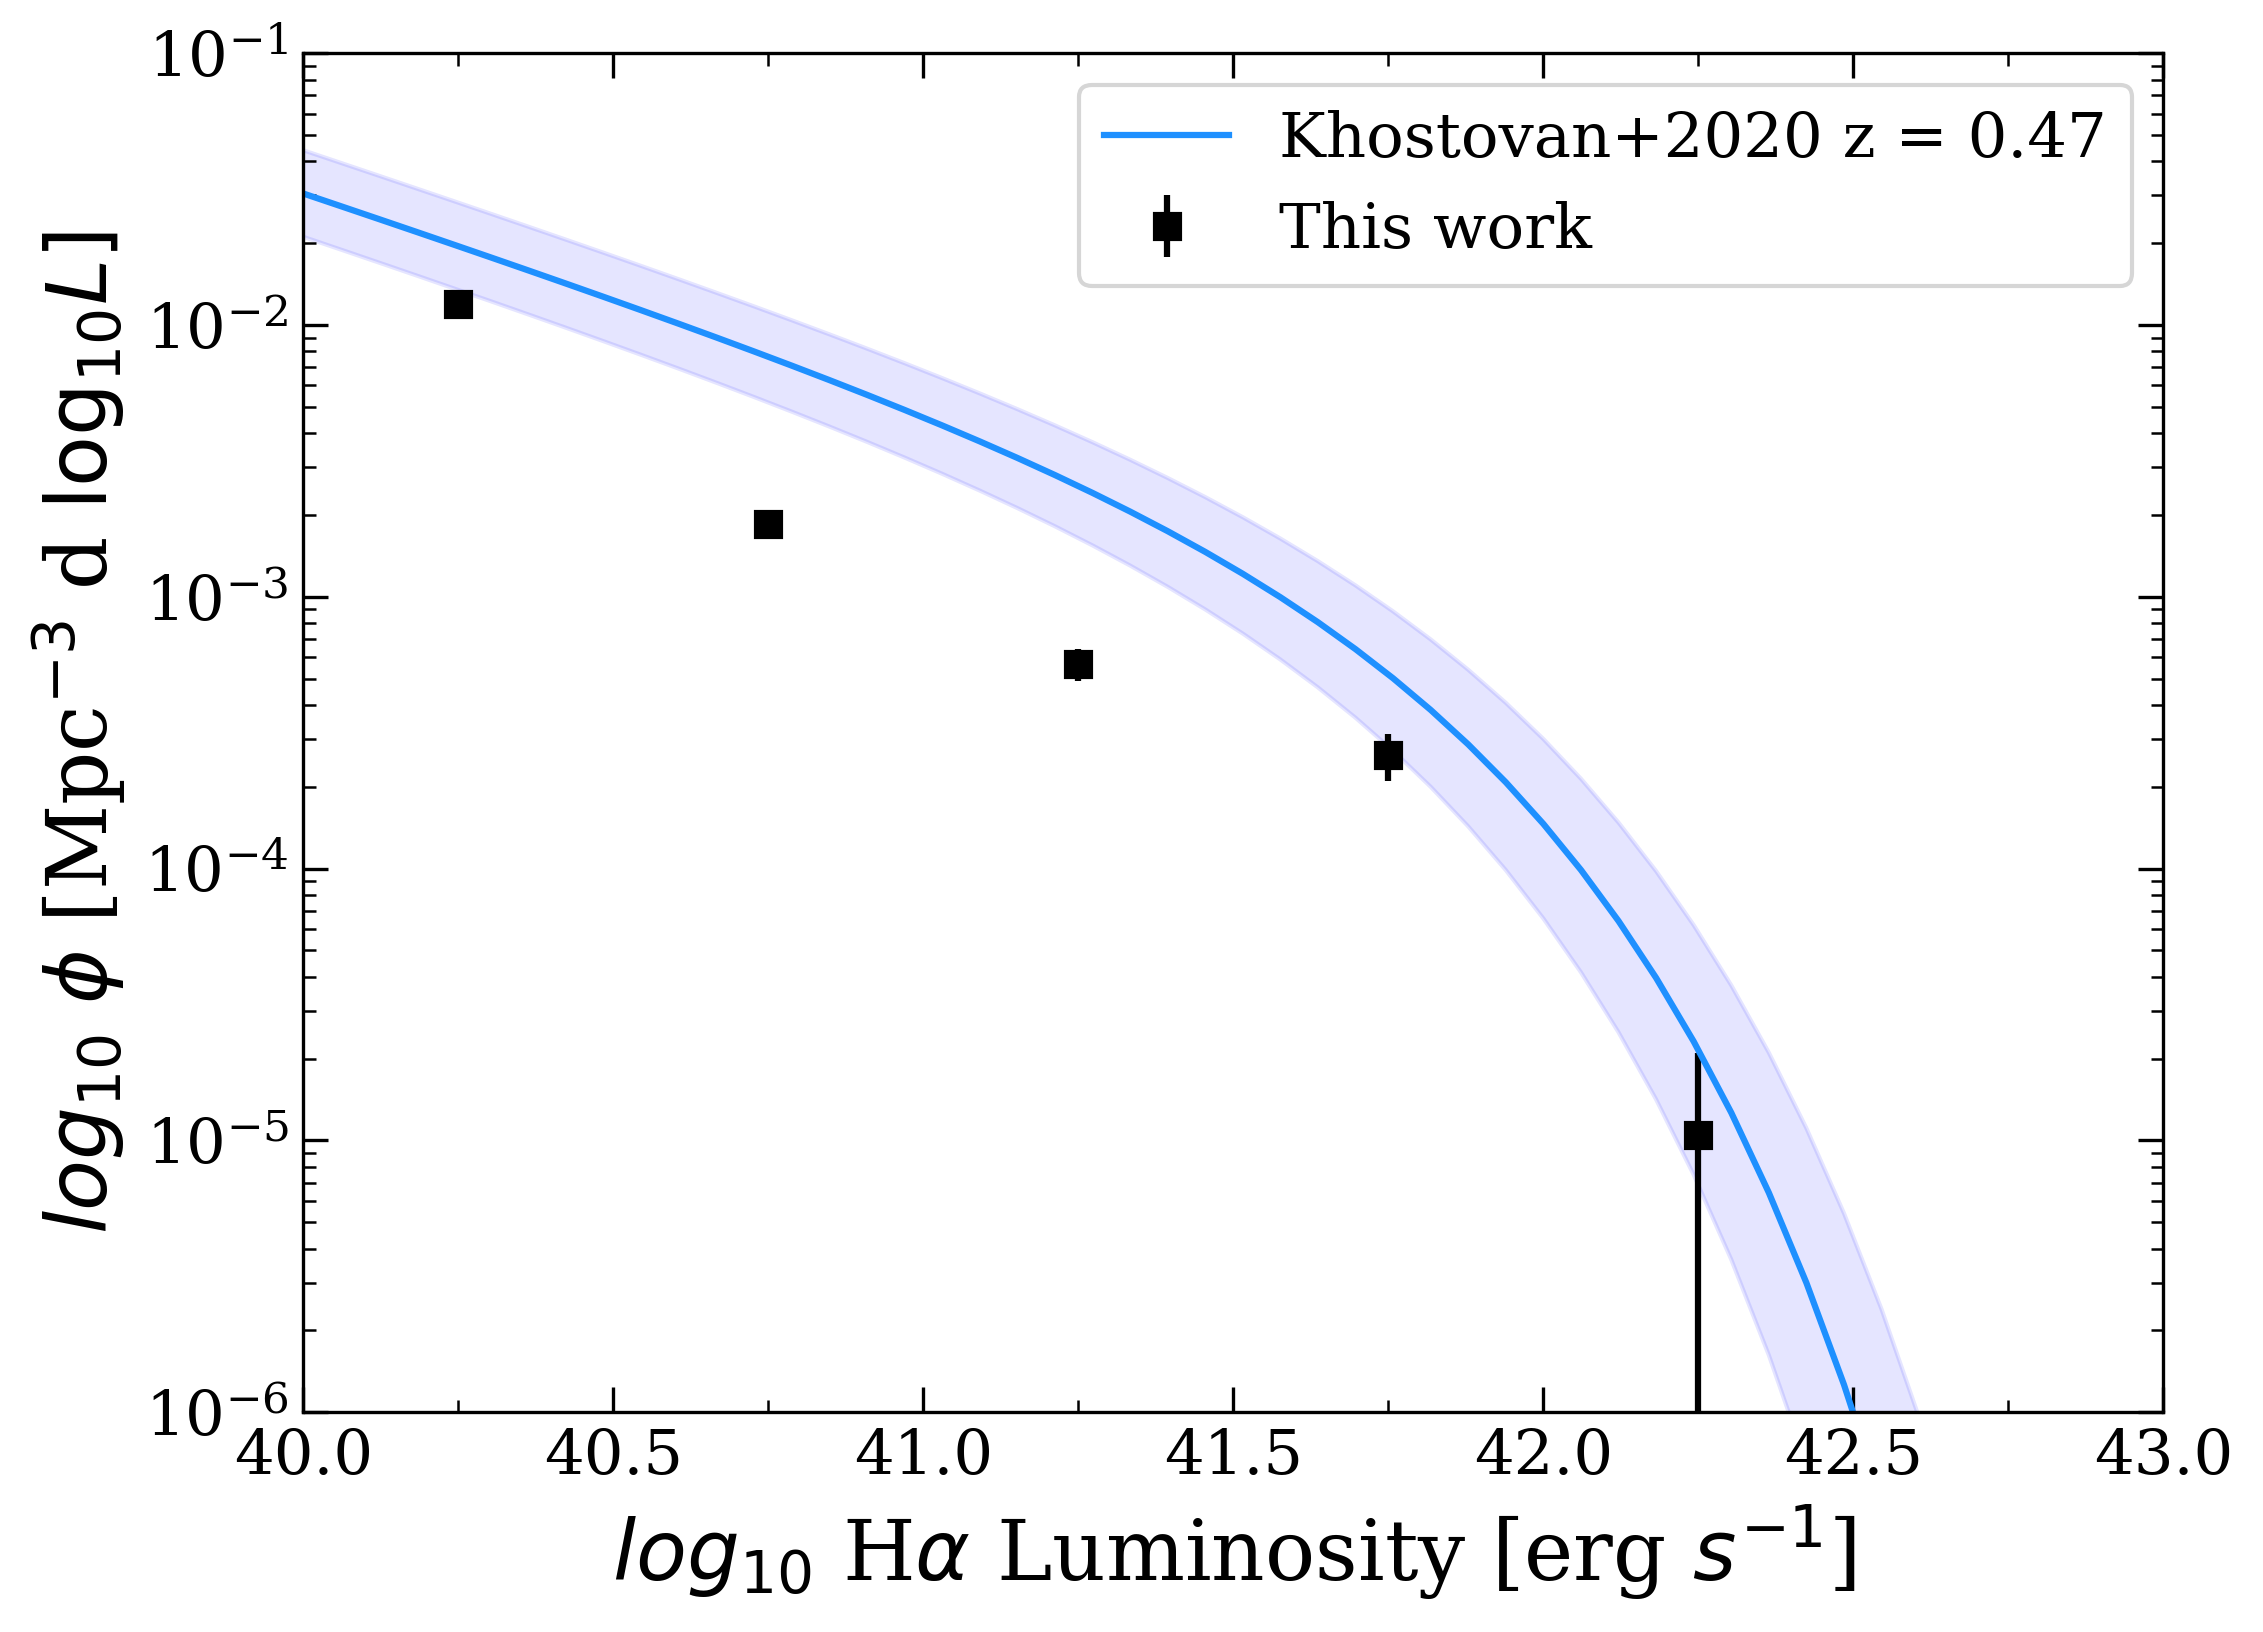

In [28]:
yy_H = alf_H/vol_H/binsize_H

#err_H = np.sqrt(1/(alf_H * np.log10(10)))
err_H = 1/np.sqrt(alf_H)

fig, ax = plt.subplots(figsize=(8,6), dpi = 300)
plt.errorbar(bx_H,yy_H,yerr = yy_H*err_H, ls = 'none', marker = 's', color = 'k', label = 'This work')
plt.fill_between(lss_H, phi_min_H, phi_max_H, alpha = 0.1, color = 'blue')
ax.plot(lss_H, phia, color = 'dodgerblue', label = 'Khostovan+2020 z = 0.47')
# ax.plot(lss_H, phi_LyHa, color = 'deepskyblue', label = 'Hayashi+2016 z = 0.4', ls = ':')
# ax.plot(lss_H, phi_LyH, color = 'darkviolet', label = 'Ly+2007 z = 0.4', ls = '--')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', left=True, right=True, direction='in', length=3)

plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40,43)

plt.xlabel(r'$log_{10}$ H$\alpha$ Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3}$ d $\log_{10} L]$')
plt.legend()
plt.show()

In [29]:
mask = yy_H > 0
yy_H2 = yy_H[mask]
bx_H2 = bx_H[mask]
err_H2 = err_H[mask]

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


Model: schechter
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
             phis                  Ls                 alpha       
    --------------------- -------------------- -------------------
    9.805833093994606e-05 8.08713222022707e+41 -1.9603949038934956


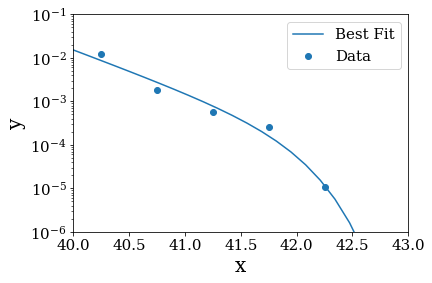

In [30]:
from astropy.modeling.models import custom_model
from astropy.modeling import models, fitting


@custom_model
def schechter(L, phis = phi_star, Ls = L_star, alpha = alpha):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha)*np.exp(-L/Ls)
    return np.log10(phi)


model = schechter()
fitter = fitting.LevMarLSQFitter()
best_fit_mH = fitter(model, 10**bx_H2, np.log10(yy_H2))
print(best_fit_mH)

x_new = np.linspace(30, 43, 100)
y_new = best_fit_mH(10**x_new)
#plt.plot(lss_H, phia, color = 'dodgerblue', label = 'Khostovan+2020 z = 0.47')
plt.scatter(bx_H2, yy_H2, label='Data')
plt.plot(x_new, 10**y_new, label='Best Fit')
plt.legend()
plt.yscale('log')
plt.xlim(40,43)
plt.ylim(1e-6,1e-1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: Runt

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWar

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWar

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: Runt

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

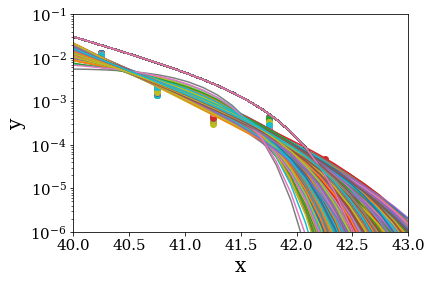

CPU times: user 47.5 s, sys: 1.85 s, total: 49.3 s
Wall time: 46.5 s


In [39]:
%%time
results = []
iterations = 2000
while len(results) < iterations:
    values_y = []
    for i, bins in enumerate(yy_H2): 
        s = np.random.normal(bins, bins*err_H2[i],1)
        values_y.append(s[0])
        
    
    values_y = np.array(values_y)

    model = schechter()
    fitter = fitting.LevMarLSQFitter()
    best_fit = fitter(model, 10**bx_H2, np.log10(values_y))
    results.append((best_fit.phis.value, best_fit.Ls.value, best_fit.alpha.value))
    
    x_new = np.linspace(30, 43, 100)
    y_new = best_fit(10**x_new)
    plt.scatter(bx_H2, values_y)
    plt.plot(x_new, 10**y_new)
    plt.yscale('log')
    plt.xlim(40,43)
    plt.ylim(1e-6,1e-1)
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

results = np.array(results)

In [40]:
res_phi = np.array([results[i][0] for i in range(len(results))])
res_Ls = np.array([results[i][1] for i in range(len(results))])
res_alpha = np.array([results[i][2] for i in range(len(results))])
phi_scs =sigma_clipped_stats(res_phi)
Ls_scs = sigma_clipped_stats(res_Ls)
alpha_scs = sigma_clipped_stats(res_alpha)
print('Erros for Phi:')
print(np.log10(best_fit_mH.phis.value))
print(np.log10(phi_scs[1])-np.log10(phi_scs[1]-phi_scs[2]))
print(np.log10(phi_scs[1])-np.log10(phi_scs[1]+phi_scs[2]))
print('Erros for Ls:')
print(np.log10(best_fit_mH.Ls.value))
print(np.log10(Ls_scs[1])-np.log10(Ls_scs[1]-Ls_scs[2]))
print(np.log10(Ls_scs[1])-np.log10(Ls_scs[1]+Ls_scs[2]))
print('Erros for alpha:')
print(best_fit_mH.alpha.value)
print((alpha_scs[1])-(alpha_scs[1]-alpha_scs[2]))
print((alpha_scs[1])-(alpha_scs[1]+alpha_scs[2]))

Erros for Phi:
-4.008515503194066
nan
-0.5545865833055044
Erros for Ls:
41.907794543647974
0.3431268514459447
-0.18926312812509138
Erros for alpha:
-1.9603949038934956
0.13484163022570184
-0.13484163022570184


/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


In [41]:
(res_alpha[1])

-1.9702424839375772

In [42]:
print(np.log10(phi_scs[1])-np.log10(phi_scs[1]-7e-5))

0.645753735046795


In [43]:
phi_star_min = 10**(-4.008515503194066 -0.52) #* (u.Mpc ** -3)
L_star_min = (10**(41.907794543647974- 0.18))
phi_min_H = sch(phi_star_min, numb_, L_star_min, -1.9603949038934956-0.13)


phi_star_max = 10**(-4.008515503194066 +0.55) #* (u.Mpc ** -3)
L_star_max = (10**(41.907794543647974 + 0.32))
phi_max_H = sch(phi_star_max, numb_, L_star_max,-1.9603949038934956 + 0.13)

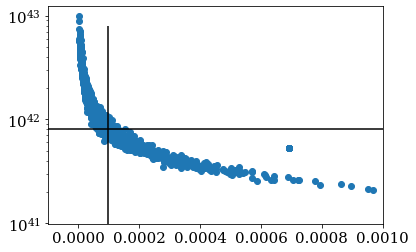

In [44]:
plt.scatter(res_phi, res_Ls)
plt.hlines(8.08713222022707e+41, -10,10)
plt.vlines(9.805833093994606e-05, 0, 8e42)
plt.xlim(-0.0001,0.001)

plt.yscale('log')

(-0.0001, 0.001)

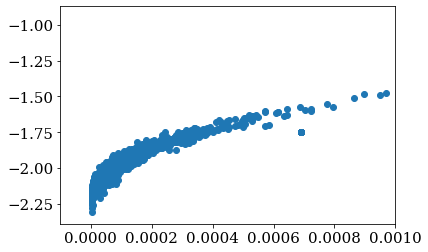

In [45]:
plt.scatter(res_phi, res_alpha)
plt.xlim(-0.0001,0.001)

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


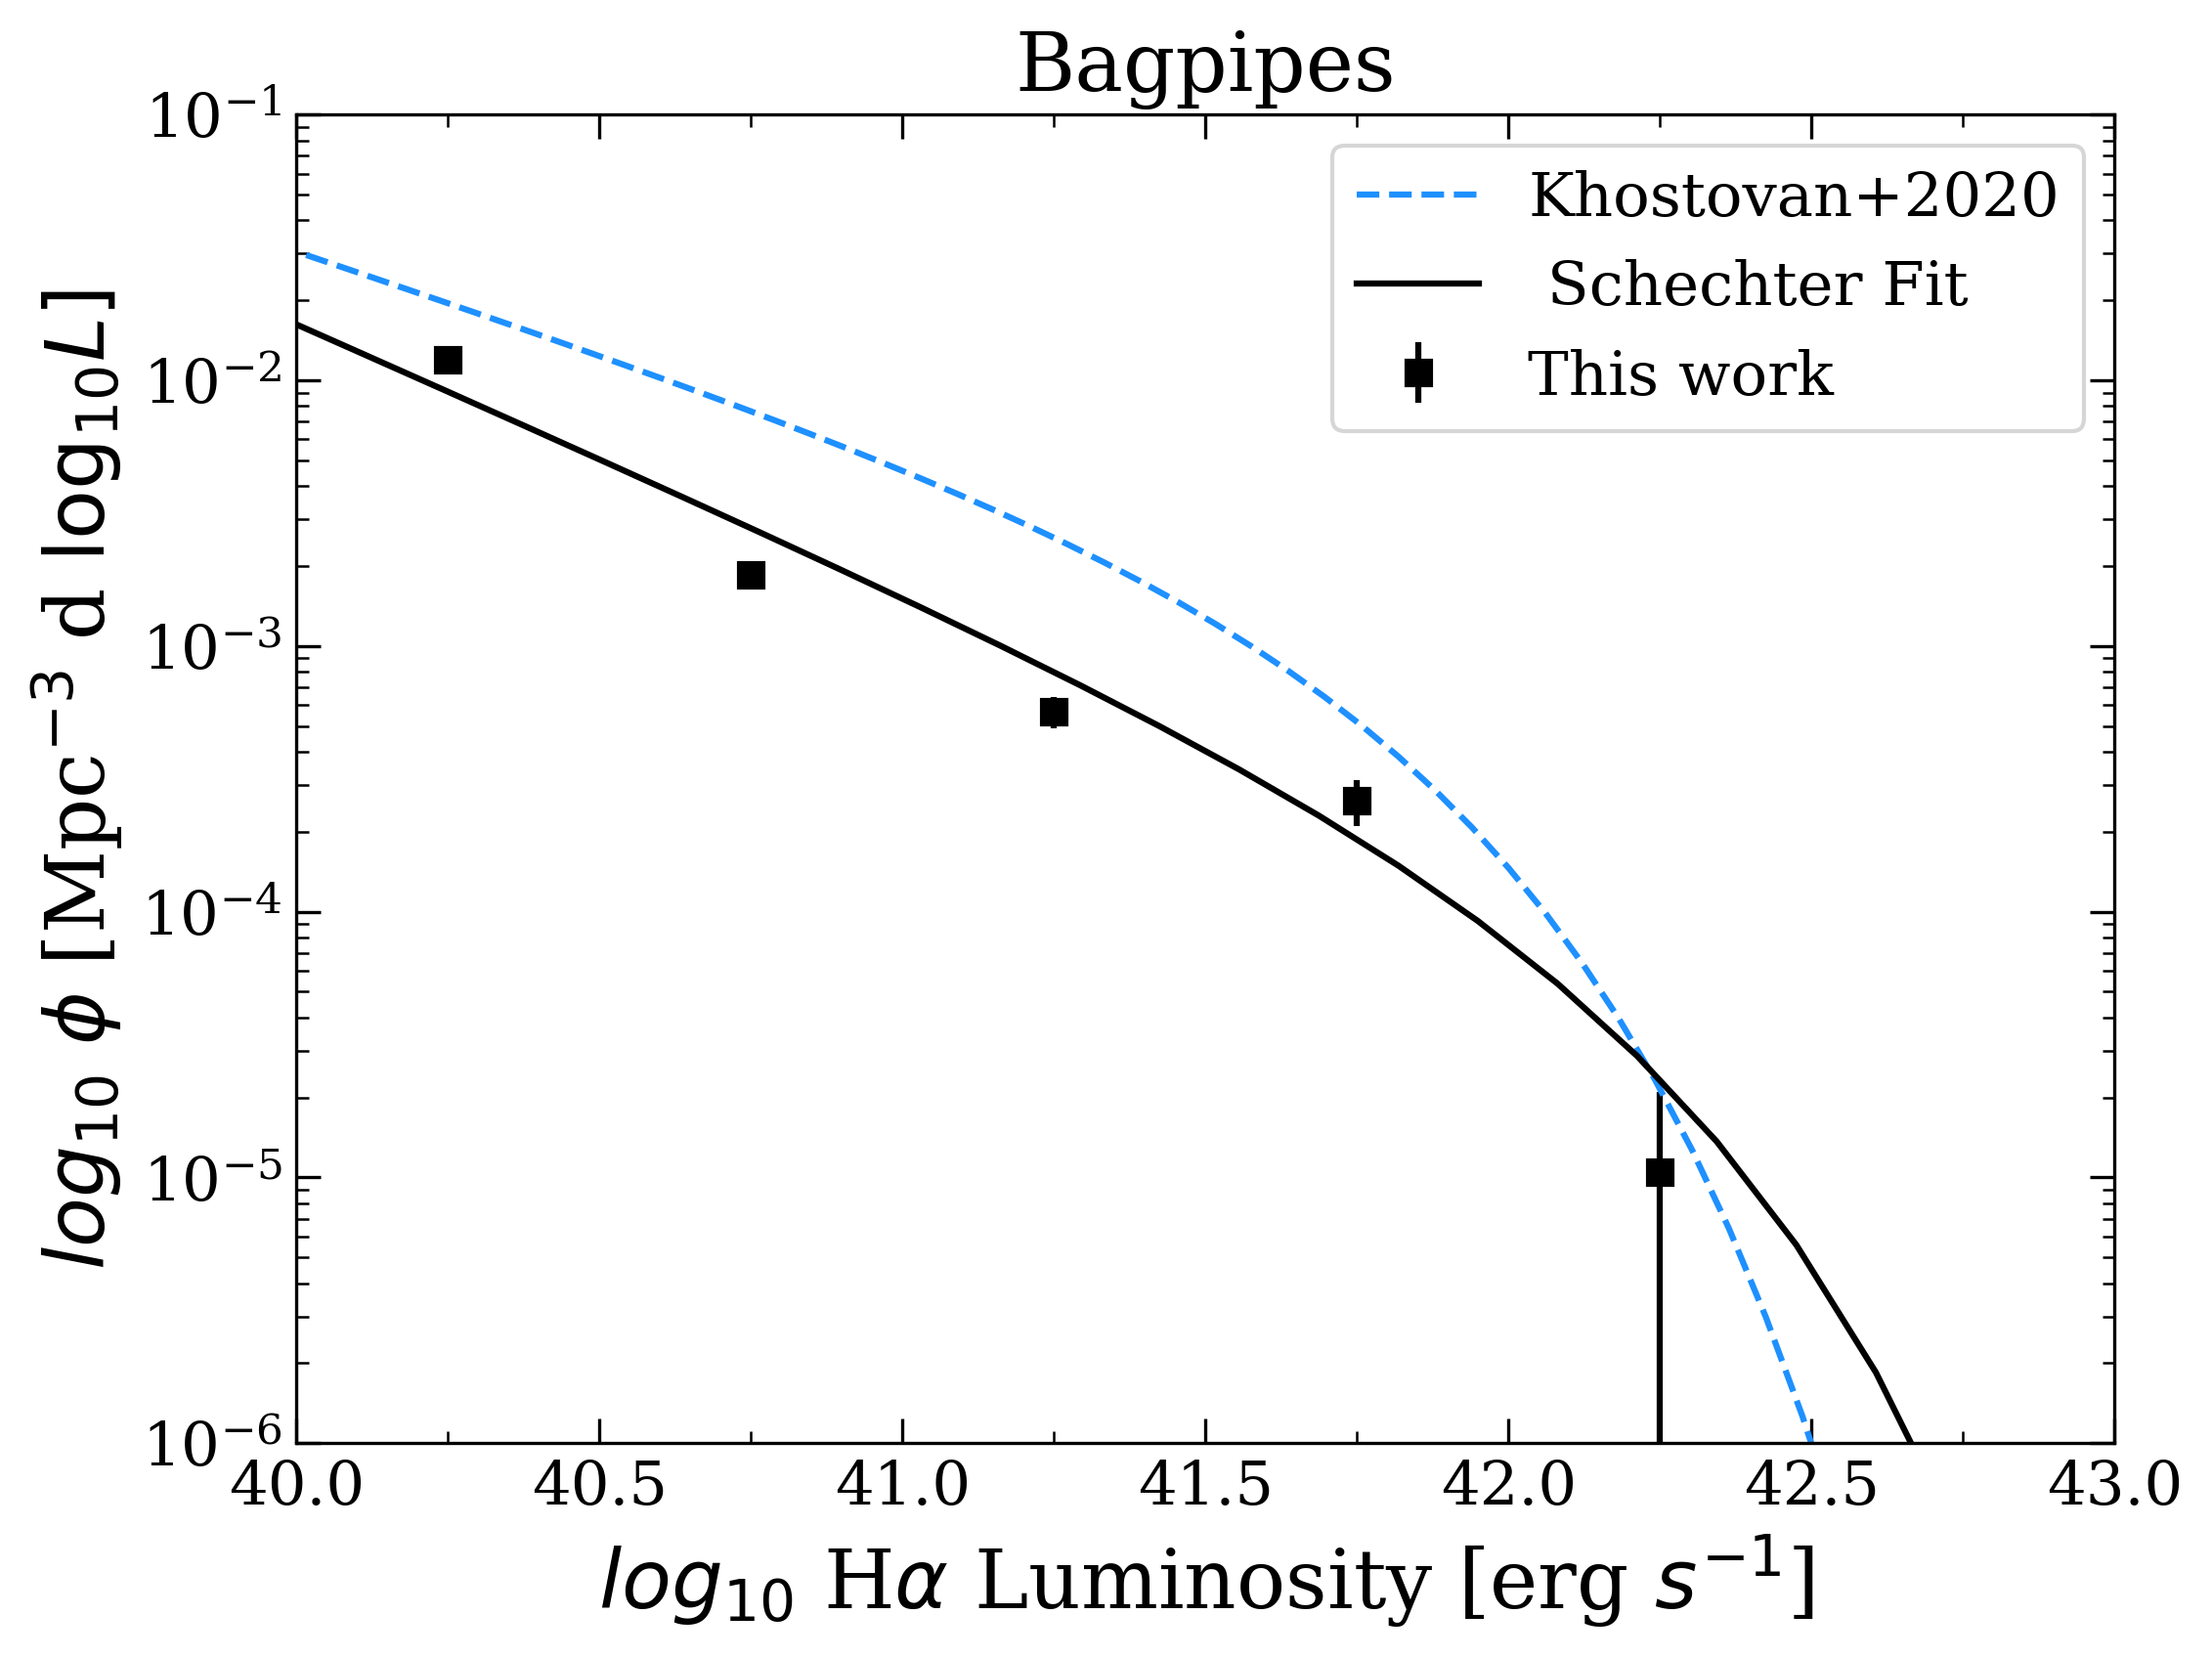

In [47]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 300)
plt.errorbar(bx_H,yy_H, yerr = yy_H*err_H, ls = 'none', marker = 's', color = 'k', label = 'This work')
#plt.fill_between(lss_H, phi_min_H, phi_max_H, alpha = 0.1, color = 'blue')
ax.plot(lss_H, phia, color = 'dodgerblue',  ls = '--',label = 'Khostovan+2020')
ax.plot(x_new, 10**y_new, label=' Schechter Fit', color = 'k')
# ax.plot(lss_H, phi_LyHa, color = 'deepskyblue', label = 'Hayashi+2016 z = 0.4', ls = ':')
# ax.plot(lss_H, phi_LyH, color = 'darkviolet', label = 'Ly+2007 z = 0.4', ls = '--')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', left=True, right=True, direction='in', length=3)

plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40,43)

plt.title('Bagpipes', size = 20)
plt.xlabel(r'$log_{10}$ H$\alpha$ Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3}$ d $\log_{10} L]$')
plt.legend()
plt.show()

# [OIII]

In [48]:
mask_2 =  (0.93-bh < data_b['redshift_50']) & (data_b['redshift_50'] < 0.93+bh)
#mask2 = (0.7 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.1)
O_III = data_b[mask_2]
print(len(O_III))

713


In [49]:
phi_star2 = 10**(-2.16) #* (u.Mpc ** -3)
L_star2 = 10**(41.38)
alpha2 = -1.60

In [50]:
OIII_mag = np.array([O_III['MAG_APER_1'][i][aper] for i in range(len(O_III))])
OIII_mag_err = np.array([O_III['MAGERR_APER_1'][i][aper] for i in range(len(O_III))])

l_OIII = flux_lum(0.93, OIII_mag, OIII_mag_err)
print(sigma_clipped_stats(l_OIII[3]))

(0.1454698786909722, 0.05674333517887913, 0.2592338931160807)


In [51]:
1/len(O_III)*np.sqrt(len(O_III))

0.037450294313656915

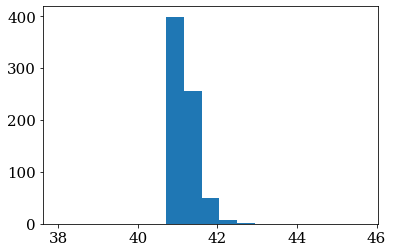

In [73]:
b2 = np.arange(38, 46,0.45)
alf_OIII, blf, clf =plt.hist(l_OIII[0], bins =b2) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [74]:
bx_OIII = (b2[0:-1]+b2[1:])/2

binsize_OIII = bx_OIII[1]-bx_OIII[0]

lss_OIII = np.linspace(38,44,100)

In [75]:
vol_OIII = volume_redshift(0.93,2.94)

numb_ =  np.logspace((38),(44),100)
phib = sch(phi_star2, numb_, L_star2, alpha2)


phi_star_min2 = 10**(-2.16 -0.12) #* (u.Mpc ** -3)
L_star_min2 = (10**(41.38-0.06))
phi_min_OIII = sch(phi_star_min2, numb_, L_star_min2, alpha2)


phi_star_max2 = 10**(-2.16 +0.1) #* (u.Mpc ** -3)
L_star_max2 = (10**(41.38 +0.07))
phi_max_OIII = sch(phi_star_max2, numb_, L_star_max2, alpha2)

In [76]:
vol_OIII

444482.2013246161

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


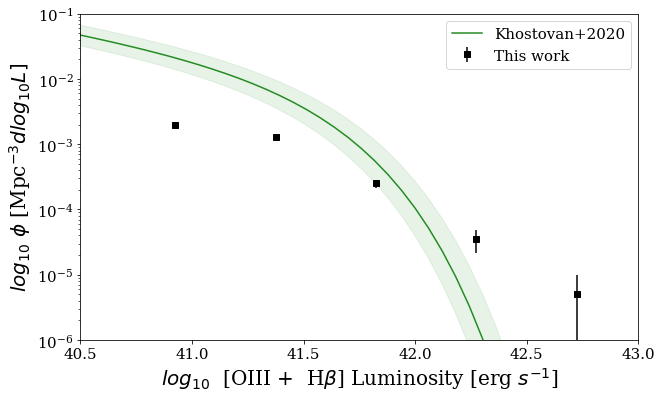

In [78]:
yy_OIII = alf_OIII/vol_OIII/binsize_OIII
err_OIII = 1/np.sqrt(alf_OIII)

fig, ax = plt.subplots(figsize = (10,6))
plt.errorbar(bx_OIII,yy_OIII,yerr = yy_OIII*err_OIII, ls = 'none', marker = 's', color = 'k' , label = 'This work' )
plt.fill_between(lss_OIII, phi_min_OIII, phi_max_OIII, alpha = 0.1, color = 'forestgreen')
plt.plot(lss_OIII, phib, color = 'forestgreen', label = 'Khostovan+2020')
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40.5,43)

plt.xlabel(r'$log_{10}$  [OIII +  H$\beta$] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.legend()
plt.show()

# [OII]

In [57]:
mask_3 =  (1.59-ch < data_c['redshift_50']) & (data_c['redshift_50'] < 1.59+cl)
#mask3 = (1.25 < table['Z_BEST'] ) & (table['Z_BEST'] < 2)
O_II = data_c[mask_3]
print(len(O_II))

1829


In [58]:
phi_star3 = 10**(-1.97) * (u.Mpc ** -3)
L_star3 =10**(41.66)
alpha3 = -1.30

In [59]:
OII_mag = np.array([O_II['MAG_APER_1'][i][aper] for i in range(len(O_II))])
OII_mag_err = np.array([O_II['MAGERR_APER_1'][i][aper] for i in range(len(O_II))])

l_OII = flux_lum(1.59, OII_mag, OII_mag_err)
print(sigma_clipped_stats(l_OII[3]))

(0.06944265684882354, 0.0430093211138408, 0.06969948428781604)


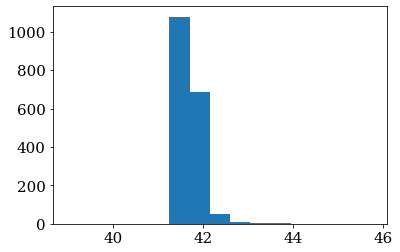

In [60]:
b3 = np.arange(39, 46,0.45)
alf_OII, blf, clf =plt.hist(l_OII[0], bins =b3) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [61]:
bx_OII = (b3[0:-1]+b3[1:])/2

binsize_OII = bx_OII[1]-bx_OII[0]

lss_OII = np.linspace(38,44,100)

In [62]:
vol_OII = volume_redshift(1.59,2.94)

numb_ =  np.logspace((38),(44),100)
phic = sch(phi_star3, numb_, L_star3, alpha3)


phi_star_min3 = 10**(-1.97 -0.07) #* (u.Mpc ** -3)
L_star_min3 = (10**(41.66 -0.03))
phi_min_OII = sch(phi_star_min3, numb_, L_star_min3, alpha3)


phi_star_max3 = 10**(-1.97 +0.07) #* (u.Mpc ** -3)
L_star_max3 = (10**(41.66 +0.03))
phi_max_OII = sch(phi_star_max3, numb_, L_star_max3, alpha3)

In [63]:
vol_OII

645906.0287183358

In [64]:
0.45/2

0.225

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


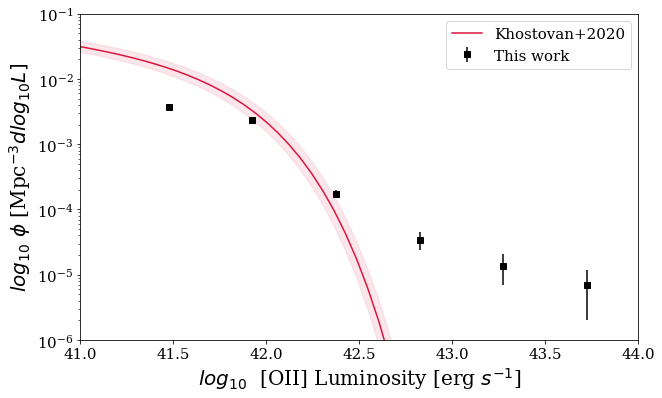

In [79]:
yy_OII = alf_OII/vol_OII/binsize_OII
err_OII = 1/np.sqrt(alf_OII)

ax,fig = plt.subplots(figsize = (10,6))
plt.errorbar(bx_OII,yy_OII, yerr = yy_OII*err_OII, ls = 'none', marker = 's', color = 'k', label = 'This work' )
plt.fill_between(lss_OII, phi_min_OII, phi_max_OII, alpha = 0.1, color = 'crimson')
plt.plot(lss_OII, phic, color = 'crimson', label = 'Khostovan+2020')
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(41,44)

plt.xlabel(r'$log_{10}$  [OII] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.legend()
plt.show()